In [24]:
!pip install langchain_community
!pip install replicate
!pip install pandas

import os
import pandas as pd
from langchain_community.llms import Replicate
from google.colab import userdata, files

In [25]:
# ==================================================
# Upload Dataset CSV (Telco Customer Churn)
# ==================================================
print("Silakan upload file CSV dataset Telco Customer Churn (misal WA_Fn-UseC_-Telco-Customer-Churn.csv):")
uploaded = files.upload()

# Ambil nama file CSV yang diunggah
filename = list(uploaded.keys())[0]
print("File yang diunggah:", filename)

# Baca dataset
df = pd.read_csv(filename)
print("Dataset dimuat. Kolom:", df.columns)
print(df.head())

Silakan upload file CSV dataset Telco Customer Churn (misal WA_Fn-UseC_-Telco-Customer-Churn.csv):


Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn (2).csv
File yang diunggah: WA_Fn-UseC_-Telco-Customer-Churn (2).csv
Dataset dimuat. Kolom: Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No   

In [26]:
# ==================================================
# Setup API Token Replicate (Granite)
# ==================================================
api_token = userdata.get('REPLICATE_API_TOKEN')  # pastikan sudah set token di colab userdata
os.environ["REPLICATE_API_TOKEN"] = api_token

# Load model Granite
model = "ibm-granite/granite-3.3-8b-instruct"
output = Replicate(model=model, replicate_api_token=api_token)

In [47]:
# ==================================================
# Definisi Parameter Model
# ==================================================
parameters_default = {
    "top_k": 0,
    "top_p": 1.0,
    "max_tokens": 256,
    "min_tokens": 0,
    "random_seed": None,
    "repetition_penalty": 1.0,
    "stopping_criteria": "length (256 tokens)",
    "stopping_sequence": None
}

parameters_refined = {
    "top_k": 5,
    "top_p": 0.9,
    "max_tokens": 500,
    "min_tokens": 20,
    "random_seed": 42,
    "repetition_penalty": 1.5,
    "stopping_criteria": "length",
    "stopping_sequence": None
}


In [53]:
# ==================================================
# Step 1: Ambil Sample Data Pelanggan
# ==================================================
samples = df.sample(3, random_state=42)
cols_to_show = ["gender", "SeniorCitizen", "Partner", "Dependents", "tenure",
                "InternetService", "Contract", "PaymentMethod",
                "MonthlyCharges", "TotalCharges", "Churn"]

customers_text = "\n".join([
    f"Pelanggan {i+1}: " + ", ".join([f"{col}: {row[col]}" for col in cols_to_show])
    for i, row in samples.iterrows()
])

In [57]:
# ==================================================
# Step 2: Prompt untuk Klasifikasi Loyalitas
# ==================================================
prompt_classify = f"""
Klasifikasikan tingkat loyalitas pelanggan berikut (Tinggi, Sedang, Rendah)
berdasarkan fitur yang tersedia. Jelaskan faktor utama yang mempengaruhi loyalitas,
misalnya harga, jenis kontrak, layanan internet, dan lama berlangganan.

Gunakan format:
- Loyalitas: [Tinggi/Sedang/Rendah]
- Faktor: [daftar faktor]

{customers_text}
"""

# Default parameters
response = output.invoke(prompt_classify, parameters=parameters_default)
print("Granite Model Response (Default Params - Klasifikasi Loyalitas):\n")
print(response)

# Refined parameters
response = output.invoke(prompt_classify, parameters=parameters_refined)
print("\nGranite Model Response (Refined Params - Klasifikasi Loyalitas):\n")
print(response)

Granite Model Response (Default Params - Klasifikasi Loyalitas):

- Pelanggan 186: Loyalitas: Rendah
  - Faktor: Tenure (1 bulan), Jenis Kontrak (Month-to-month), Layanan Internet (DSL), Harga (dengan biaya mingguan yang relatif rendah tetapi akhirnya mencurahkan pelanggan keluar), dan Metode Pembayaran (elektronis cek).
  - Pelanggan ini memiliki tenure yang sangat pendek, kontrak bulanan, dan menggunakan layanan DSL. Meskipun biaya mingguan mungkin terlihat rendah, jumlah yang dibayarkan secara keseluruhan mungkin tidak memadai untuk menunjukkan komitmen yang kuat. Pilihan metode pembayaran cek mungkin juga menunjukkan kecenderungan untuk lebih terlibat dalam transaksi. Pelanggan ini akhirnya melakukan pengeluaran (churn).

- Pelanggan 2716: Loyalitas: Tinggi
  - Faktor: Tenure (41 bulan), Jenis Kontrak (Month-to-month), Layanan Internet (tidak tersedia), Metode Pembayaran (transfer bank otomatis), Harga (biaya yang relatif stabil selama 41 bulan), dan Lama Berlangganan (panjang wakt

In [60]:
# ==================================================
# Step 3: Prompt untuk Analisis Faktor Umum
# ==================================================
prompt_analysis = f"""
Analisis keseluruhan dataset pelanggan.
Ringkas faktor-faktor utama yang mempengaruhi tingkat loyalitas pelanggan,
dan berikan 3 rekomendasi strategi bisnis singkat untuk meningkatkan loyalitas.
"""

# --- Default parameters ---
response = output.invoke(prompt_analysis, parameters=parameters_default)
print("\nGranite Model Response (Default Params - Analisis Faktor Umum):\n")
print(str(response), flush=True)
del response
# --- Refined parameters ---
response = output.invoke(prompt_analysis, parameters=parameters_refined)
print("\nGranite Model Response (Refined Params - Analisis Faktor Umum):\n")
print(str(response), flush=True)
del response


Granite Model Response (Default Params - Analisis Faktor Umum):

Untuk melakukan analisis keseluruhan dataset pelanggan dan mengidentifikasi faktor-faktor utama yang mempengaruhi tingkat loyalitas pelanggan, langkah-langkah yang dapat dilakukan adalah sebagai berikut:

1. **Data Collection dan Pembersihan**: Jelajahi dataset pelanggan untuk mengumpulkan informasi seperti transaksi, interaksi dengan layanan pelanggan, demografi pelanggan, dan waktu yang mereka menghabiskan pada aplikasi atau layanan tertentu. Pastikan data tersebut telah dipersiapkan dengan benar dan dibekali untuk menghindari keterlambatan atau kesalahan.

2. **Analisis Statistik Deskriptif**: Lakukan analisis deskriptif untuk memahami profil pelanggan, termasuk faktor-faktor demografis, jenis transaksi, waktu aktif, dan lainnya.

3. **Analisis Pertanyaan Pelanggan (CSAT/NPS)**: Jelajahi data dari pertanyaan kepuasan pelanggan (CSAT) dan Net Promoter Score (NPS) untuk melihat tingkat kepuasan dan keberlanjutan rekomen

In [62]:
# ==================================================
# Step 4: Prompt untuk Output Terstruktur
# ==================================================
prompt_structured = f"""
Tampilan hasil analisis loyalitas pelanggan dalam format terstruktur:

- Faktor Utama Loyalitas
- Faktor Utama Churn
- Rekomendasi Strategi (3 poin)

Gunakan dataset pelanggan yang sudah diberikan.
"""

response = output.invoke(prompt_structured, parameters=parameters_refined)
print("\nGranite Model Response (Structured Insight):\n")
print(response)



Granite Model Response (Structured Insight):

Untuk menampilkan hasil analisis loyalitas pelanggan dengan format yang terstruktur sebagaimana diminta, saya akan menyajikan contoh yang hypotetis, karena saya tidak memiliki akses direkt ke dataset pelanggan yang Anda berikan. Namun, saya akan menjelaskan bagaimana Anda dapat mengorganisir dan meninterpretasi hasil analisis loyalitas pelanggan.

### Hasil Analisis Loyalitas Pelanggan

#### 1. Faktor Utama Loyalitas

- **Faktor 1: Kualitas Produk/Layanan**
  - **Contribusi**: 35%
  - **Deskripsi**: Pelanggan menunjukkan kepuasan tinggi dengan kualitas produk/layanan yang diberikan. Ukuran kepuasan ini terkait dengan ketersediaan produk, keberfungsiannya, dan pelayanan customed yang baik.

- **Faktor 2: Program Loyalty**
  - **Contribusi**: 28%
  - **Deskripsi**: Program pelayanan loyalitas yang kuat, seperti poin, diskon, atau reward, memiliki dampak signifikan terhadap loyalitas pelanggan. Pelanggan merasa dihargai dan lebih proaktif unt

/tmp/ipython-input-1958675608.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Churn", palette="Set2")


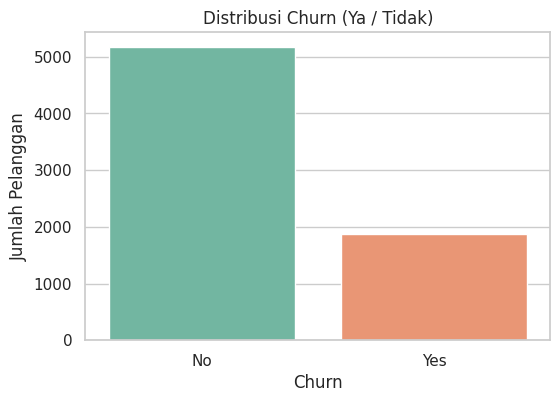

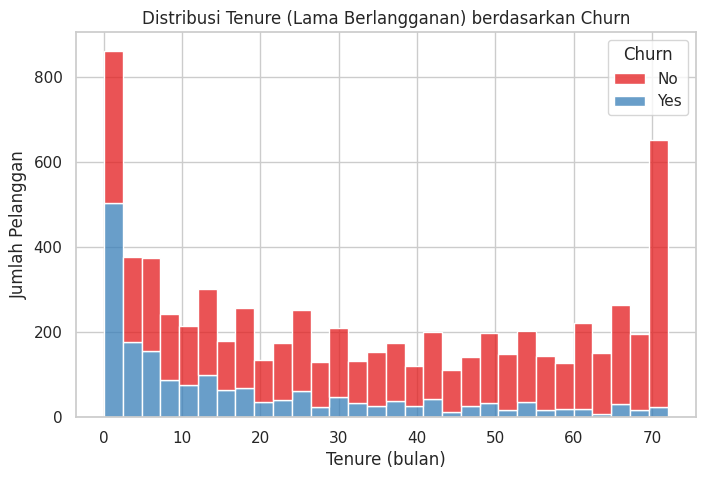

/tmp/ipython-input-1958675608.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="Churn", y="MonthlyCharges", palette="coolwarm")


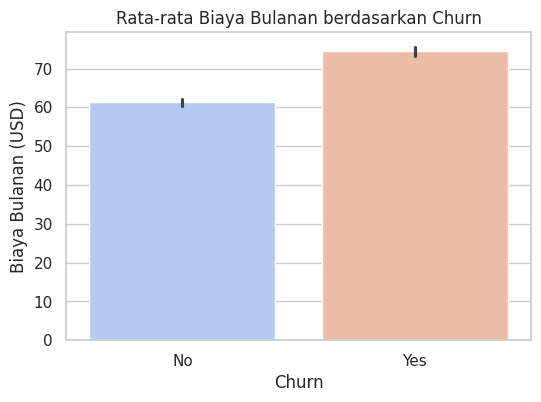

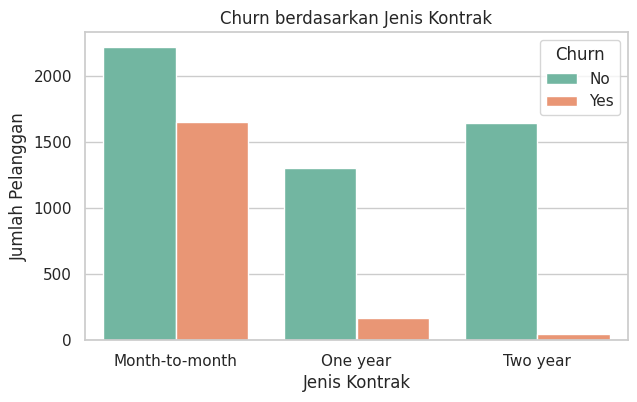

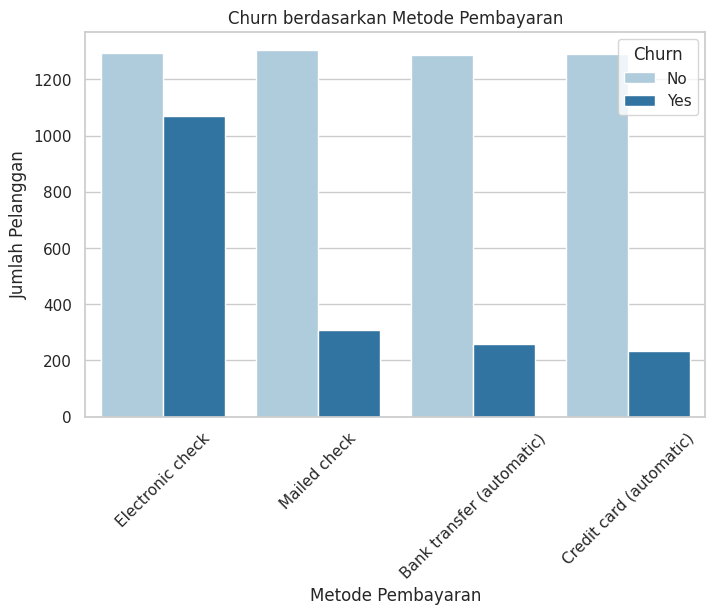

In [64]:
# ==================================================
# Step 4: Visualisasi Data Telco Customer Churn
# ==================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Setting style
sns.set(style="whitegrid")

# 1. Distribusi Churn
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Churn", palette="Set2")
plt.title("Distribusi Churn (Ya / Tidak)")
plt.xlabel("Churn")
plt.ylabel("Jumlah Pelanggan")
plt.show()

# 2. Distribusi Tenure berdasarkan Churn
plt.figure(figsize=(8,5))
sns.histplot(data=df, x="tenure", hue="Churn", multiple="stack", bins=30, palette="Set1")
plt.title("Distribusi Tenure (Lama Berlangganan) berdasarkan Churn")
plt.xlabel("Tenure (bulan)")
plt.ylabel("Jumlah Pelanggan")
plt.show()

# 3. Rata-rata Monthly Charges berdasarkan Churn
plt.figure(figsize=(6,4))
sns.barplot(data=df, x="Churn", y="MonthlyCharges", palette="coolwarm")
plt.title("Rata-rata Biaya Bulanan berdasarkan Churn")
plt.ylabel("Biaya Bulanan (USD)")
plt.show()

# 4. Perbandingan Churn berdasarkan Jenis Kontrak
plt.figure(figsize=(7,4))
sns.countplot(data=df, x="Contract", hue="Churn", palette="Set2")
plt.title("Churn berdasarkan Jenis Kontrak")
plt.xlabel("Jenis Kontrak")
plt.ylabel("Jumlah Pelanggan")
plt.legend(title="Churn")
plt.show()

# 5. Perbandingan Churn berdasarkan Payment Method
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="PaymentMethod", hue="Churn", palette="Paired")
plt.title("Churn berdasarkan Metode Pembayaran")
plt.xticks(rotation=45)
plt.xlabel("Metode Pembayaran")
plt.ylabel("Jumlah Pelanggan")
plt.legend(title="Churn")
plt.show()

